In [1]:
import radvel
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
import celmech as cm
import pandas as pd
import h5py

Set up model using $K_1$, $\frac{m_2}{m_1}$, $e_1$, $\omega_1$, $\dot{\omega}$, $P_1$, $\lambda_1$ or $M_1$:

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
hd_data.BJD -= 2.4e6

cluster_data = h5py.File('hd_mcmc_cluster.h5', 'r')  # import the posterior distribution data from the cluster
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

n_burn_in = 200  # discard the first 200 samples as burn-in time
# reshape the chain to flatten it out
flat_samples = samples[n_burn_in:].reshape(-1, samples[n_burn_in:].shape[-1])

Model -- use RV model in equilibrium. First find the constant $c$ in $\frac{e_1}{e_2} = c \times \frac{m_2}{m_1}$, using the `REBOUNDx` eccentricity track simulations:

In [3]:
nsims = 100
Ks_orig = np.logspace(0, 5, nsims)
ecc_sims_location = 'hd_max_mass'
# initialize c array
cs = np.zeros(len(Ks_orig))

for i in range(0, len(Ks_orig)):
    ecc_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = ecc_sim.particles[1]
    outer = ecc_sim.particles[2]
    # print(inner.m, outer.m)
    cs[i] = (inner.e * inner.m)/(outer.e * outer.m)  # compute c by rearranging

In [4]:
np.median(cs)

0.9067963293569362

(array([ 1.,  4.,  2.,  3.,  2.,  3., 10., 29., 31., 15.]),
 array([0.19111961, 0.28128896, 0.37145831, 0.46162766, 0.55179701,
        0.64196636, 0.73213571, 0.82230506, 0.91247441, 1.00264376,
        1.09281311]),
 <BarContainer object of 10 artists>)

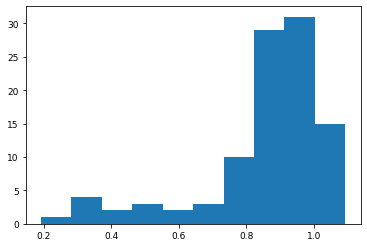

In [5]:
plt.hist(cs)

Create rv

In [6]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor to convert from au/day --> m/s

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, inclination, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, inclination, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

Parameters ($K_1, \frac{m_2}{m_1}, e_1, \omega_1, \dot\omega, P_1, \lambda_1$ or $M_1$):

In [7]:
test_samp = flat_samples[2000]

In [8]:
# test parameters
time_base = np.median(hd_data.BJD)
fit_sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = time_base)
# 7 parameters
k1 = test_samp[1]# /AUDAY_MS  # k1
e1 = test_samp[3] ** 2 + test_samp[4] ** 2  # e1
p1 = test_samp[0]  # p1
Tprecess = 50 * p1
m2_m1 = fit_sim.particles[2].m/fit_sim.particles[1].m
omega1 = np.arctan2(test_samp[3], test_samp[4])
# use from the precessingrvsignal notebook
omegadot = 2 * np.pi /Tprecess  # omegadot = omegadot1 = omegadot2
tp1 = radvel.orbit.timetrans_to_timeperi(test_samp[2], per = p1, ecc = e1, omega = omega1)
# and the constant c, using the median as the constant
c = 1.07

# compute tihngs needed

# compute m1 from K1 and e1 using semiamp_to_mass
m1 = semiamp_to_mass(semiamp = k1/AUDAY_MS, star_mass = STAR_MASS, period = p1, eccentricity = e1, inclination = np.pi/2)
# compute m2 using m1 and m2/m1 as a parameter
m2 = m2_m1 * m1
# compute e2 using e1, m1, m2
e2 = (e1 * m1)/(c * m2)
# compute p2 usng omegadot, since thetadot1 = thetadot2 = 0
p2 = (3 * np.pi * p1)/(2 * np.pi + p1 * omegadot)  # rearrange the equation
# compute K2 using m2, e2, and p2
k2 = mass_to_semiamp(planet_mass = m2, star_mass = STAR_MASS, period = p2, eccentricity = e2, inclination=np.pi/2) * AUDAY_MS
# compute omega2 as omega1 + pi
omega2 = omega1 + np.pi
# compute mean anomalies M1, M2



# TODO:
# convert tp to lambda, and compute lambda1 and lambda2
# also compute theta1 and 2 as well (note that theta1 = theta2 + (either 0 or pi))

In [9]:
tp1, radvel.orbit.timetrans_to_timeperi(test_samp[7], per = p2, ecc = e2, omega = omega2)  # tp1 and tp2 values

(53827.057742615485, 54024.829734942985)

In [10]:
def get_mean_anomaly(t, period, tp):
    """
    Gets mean anomaly at a specified time t, given the period P of the planet and the time of pericenter passage tp
    
    Mean anomaly is in radians
    """
    return ((2 * np.pi)/period) * (t - tp)
    

Compare fit params and this:

In [11]:
fit_params  # p1, k1, tc1, sqrt(e1) * cos(omega1), sqrt(e1) * sin(omega1) and same for 2, plus rv offset at the end

[228.513053, 7.27743508, 53937.189, -0.178110513, -0.0466450116, 343.378023, 1
7.8603199, 54018.675, 0.13216504, 0.0973129308, -0.529039776]

In [12]:
p1, k1, e1, m1, p2, k2, e2, m2

(228.57044652960857, 7.305026710113224, 0.023988316851047867, 0.20152652656450
432, 336.1330096023656, 18.056644027326843, 0.007973687736480968, 0.5666162096
957676)

In [13]:
# ?get_sim_from_params

In [14]:

# radvel.kepler.rv_drive(p1, )

In [15]:
import sympy as sp

l1, l2, omegai = sp.symbols('lambda1, lambda2, omega_i')
thetai = sp.symbols('theta_i')
M1, M2, p1, p2, t, Tp1, Tp2 = sp.symbols('M1, M2, p1, p2, t, Tp1, Tp2')
omega1, omega2 = sp.symbols('omega1, omega2')

n = 0

# resonant angle equation
thetai = 3 * l2 - 2 * l1 - omegai
# rearranging Mi = lambdai - omegai and substituting in
thetai = thetai.subs([(l1, M1 + omega1), (l2, M2 + omega2 - n * (2/3 * np.pi))])
# then substitute M = 2pi/P (t - Tp) for both
thetai = thetai.subs([(M1, (2 * np.pi)/p1 * (time_base - Tp1)), (M2, (2 * np.pi)/p2 * (time_base - Tp2))])
# substitute t = 0 since it doesn't matter, and then omegai = omega2 here, and omega1 = omega2 + pi) 
thetai = thetai.subs([(t, 0), (omegai, omega2), (omega1, omega2 + np.pi)])
# finally solve for Tp2 in terms of Tp1, p1 and p2:
tp2_expr = sp.solve(thetai, Tp2)[0]

In [16]:
tp2_expr, tp2_expr.subs([(p1, test_samp[0]), (p2, test_samp[5]), (Tp1, 53827)])  # tp2 should be 54024

⎛4.24413181578387e-24⋅(1.5707963267949e+23⋅Tp₁⋅p₂ + p₁⋅(1.2830127289518e+28 - 
⎜─────────────────────────────────────────────────────────────────────────────
⎝                                                              p₁             

7.85398163397449e+22⋅p₂) - 8.553418193012e+27⋅p₂)                  ⎞
─────────────────────────────────────────────────, 53711.7920324578⎟
                                                                   ⎠

In [17]:
0 - (2 * test_samp[5])/(3 * test_samp[0]) * (0 - 53827)

53894.11634619993

In [18]:
test_samp

array([ 2.28570447e+02,  7.30502671e+00,  5.39365326e+04, -1.53652046e-01,
        1.94773112e-02,  3.43283173e+02,  1.78184523e+01,  5.40181909e+04,
        1.43601538e-01,  1.11396398e-01, -6.68446640e-01])

Need $P_1, T_{p1}, e_1, \omega_1, K_1$ explicitly, and implement $\dot\omega$ in the same way in the precessing rv signal notebook ($12$ parameters) to build the `radvel.kepler.rv_drive()` forward model

Write a function that returns an RV signal for a given set of 7 parameters assuming equilibrium:

In [19]:
time_base = np.median(hd_data.BJD)

In [30]:
def get_rv_signal_equilibrium(times, params, c, time_base):
    """
    Gets an RV signal under the equilibrium constraints using the radvel.kepler.rv_drive() function
    for a set of 7 equilibrium parameters as well as the constant c in the equation e1/e2 = c * m2/m1,
    and the base time time_base
    
    Params are in the order K1, m2/m1, e1, omega1, omegadot, P1, Tp1, rv_offset
    
    k1: semi-amplitude of the inner planet, in m/s
    m2/m1: ratio of outer planet to inner planet's mass, dimensionless
    e1: eccentricity of inner planet, dimensionless
    omega1: argument of pericenter of inner planet, radians
    omegadot: rate of precession (omegadot = omegadot_1 = omegadot_2), UNITS
    p1: period of inner planet, days
    tp1: time of pericenter passage of inner planet
    rv_offset: rv offset of star, in m/s
    
    return tuple of keplerian and rebound rvs, both generated using the set of parameters passed
    
    kep_rvs: keplerian forward model (using radvel.kepler.rv_drive() function) rvs, m/s
    rb_rvs: rebound rvs, m/s
    """
    k1, m2m1, e1, omega1, omegadot, p1, tp1, rv_offset = params  # params are in this order
    # compute m1 from K1 and e1 using semiamp_to_mass
    # divide the semi amplitude by auday_ms since it is given in m/s and semiamp_to_mass takes it in au/day
    m1 = semiamp_to_mass(semiamp = k1/AUDAY_MS, star_mass = STAR_MASS, period = p1, eccentricity = e1, inclination = np.pi/2)
    # compute m2 using m1 and m2/m1 as a parameter
    m2 = m2m1 * m1
    # compute e2 using e1, m1, m2 and the constant c
    e2 = (e1 * m1)/(c * m2)
    # compute p2 usng omegadot, since thetadot1 = thetadot2 = 0
    p2 = (3 * np.pi * p1)/(2 * np.pi + p1 * omegadot)  # rearrange the equation
    # compute K2 using m2, e2, and p2
    # multiply the resulting semi amplitude by auday_ms to get into m/s since mass_to_semiamp returns it in au/day
    k2 = mass_to_semiamp(planet_mass = m2, star_mass = STAR_MASS, period = p2, eccentricity = e2, inclination=np.pi/2) * AUDAY_MS
    # compute omega2 as omega1 + pi
    omega2 = omega1 + np.pi
    # finally compute Tp2
    tp2 = time_base - p2/2 - (2/3) * (p2/p1) * (time_base - tp1)
    # then put these into the radvel.kepler.rv_drive() function:
    # p1, tp1, e1, omega1, k1, plus omegadot implemented using list comprehension and adding t * omegadot to omega1
    inner_signal = np.array([radvel.kepler.rv_drive(np.array([t]), [p1, tp1, e1, omega1 + t * omegadot, k1]) for t in times]).reshape(-1)
    # same for outer
    outer_signal = np.array([radvel.kepler.rv_drive(np.array([t]), [p2, tp2, e2, omega2 + t * omegadot, k2]) for t in times]).reshape(-1)
    # return the sum of the two signals (since it's keplerian), plus the constant rv offset
    kep_rvs = inner_signal + outer_signal + rv_offset
    # now generate rvs from rebound using these parameters and a couple others
    # time of conjunction
    tc1 = radvel.orbit.timeperi_to_timetrans(tp1, p1, e1, omega1)
    tc2 = radvel.orbit.timeperi_to_timetrans(tp2, p2, e2, omega2)
    # sesin and secos
    secos1, sesin1 = np.sqrt(e1) * np.array([np.cos(omega1), np.sin(omega1)])
    secos2, sesin2 = np.sqrt(e2) * np.array([np.cos(omega2), np.sin(omega2)])
    # rebound parameters
    rb_params = [p1, k1, tc1, secos1, sesin1, p2, k2, tc2, secos2, sesin2, rv_offset]
    # get rvs using this
    rb_rvs = get_rvs(rb_params, inclination = np.pi/2, times= times, integrator = 'ias15', time_base = time_base)
    # return both keplerian and rebound rvs as a tuple
    return kep_rvs, rb_rvs, rb_params
    

Use parameters from the best-fit value from the least-squares (or posterior):

In [21]:
fit_params

[228.513053, 7.27743508, 53937.189, -0.178110513, -0.0466450116, 343.378023, 1
7.8603199, 54018.675, 0.13216504, 0.0973129308, -0.529039776]

Also use these params to find the resonant libration angles:

In [32]:
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = time_base)
# inner, outer planets
sim_inner = sim.particles[1]
sim_outer = sim.particles[2]
# generate tiem array
times = np.linspace(time_base, time_base + sim_inner.P * 50, int(1e4))  # 50 orbital periods
# use c from earlier, use time_base time_base, and use the parameters determined from sim:
k1 = mass_to_semiamp(sim_inner.m, star_mass=STAR_MASS, period=sim_inner.P, eccentricity=sim_inner.e, inclination=np.pi/2) * AUDAY_MS  # semiamplitude for first
m2m1 = sim_outer.m/sim_inner.m  # ratio of m2 to m1
e1 = sim_inner.e  # eccentricity
omega1 = sim_inner.omega  # omega
omegadot = 0  # 2 * np.pi/(50 * sim_inner.P)  # just use 0 at first and then change this slowly i guess, should be very small
p1 = sim_inner.P   # period
tp1 = sim_inner.T  # time of pericenter passage
rv_offset = fit_params[-1]

# all seven parameters together:
eq_model_params = [k1, m2m1, e1, omega1, omegadot, p1, tp1, rv_offset]
eq_model_params, c

([7.277435079999999, 2.811620977918289, 0.033899111948287694, 3.39772837942249
3, 0, 228.51305300000024, 54458.258433793715, -0.529039776], 1.07)

Generate RV signal from equilibrium forward model, compare to a `REBOUND`-generated one:

In [36]:
times = np.linspace(time_base, time_base + fit_params[0] * 10, int(1e4))
# equilibrum forward model and rebound rv model using c and time_base
eq_rv_signal, rb_rv_signal, rb_params = get_rv_signal_equilibrium(times, eq_model_params, c, time_base)
# rb_rv_signal = get_rvs(fit_params, np.pi/2, times, integrator='ias15', time_base = time_base)

eq_rv_signal, rb_rv_signal

(array([-25.46282672, -25.44644636, -25.42944257, ...,  -1.55885041,
         -1.62581388,  -1.69255551]),
 array([-25.45136958, -25.43500121, -25.4180097 , ...,   1.1751237 ,
          1.13585379,   1.09668223]))

Plot resonant angles using `rb_params`:

In [37]:
rb_params

[228.51305300000024, 7.277435079999999, 54394.215105999996, -0.178110513000001
1, -0.046645011599999994, 342.76957950000036, 17.865530756757177, 54357.406199
17049, 0.10268790134536171, 0.026892732319703166, -0.529039776]

In [51]:
theta1, theta2 = np.zeros(len(times)), np.zeros(len(times))
sim = get_sim_from_params(rb_params, np.pi/2, 'ias15', time_base)
inner = sim.particles[1]
outer = sim.particles[2]
# get the resonant angles 
for i, t in enumerate(times):
     # 
    sim.integrate(t)
    resonant_angle = 3 * outer.l - 2 * inner.l
    theta1[i] = resonant_angle - inner.pomega
    theta2[i] = resonant_angle - outer.pomega

Plto:

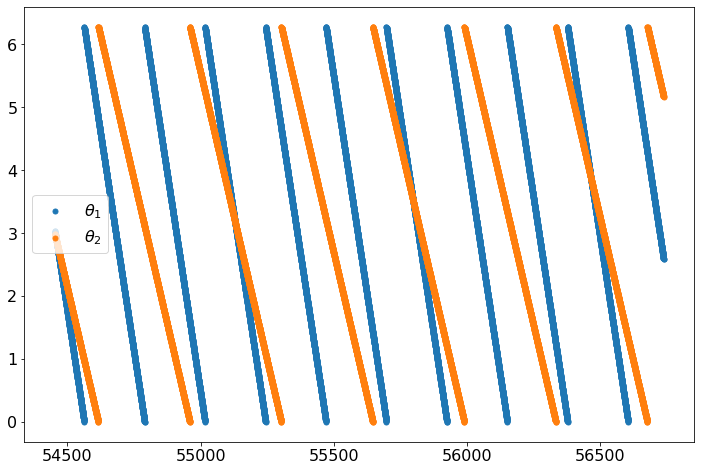

In [52]:
plt.figure(figsize = (12, 8))
plt.scatter(times, theta1, label = r'$\theta_1$')
plt.scatter(times, theta2, label = r'$\theta_2$')
plt.legend()

Plot RV signals to compare:

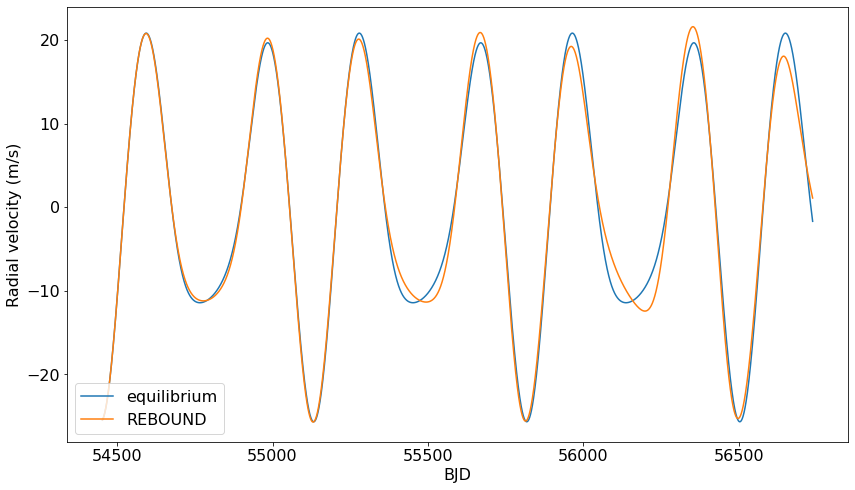

In [34]:
plt.figure(figsize = (14, 8))
plt.rc('font', size = 16)
# Keplerian RV signal generated by the equilibrium forward model
plt.plot(times, eq_rv_signal, label = 'equilibrium')
# n-body RV signal generated by REBOUND
plt.plot(times, rb_rv_signal, label = 'REBOUND')
# label
plt.xlabel('BJD'), plt.ylabel('Radial velocity (m/s)')
plt.legend()
plt.show()

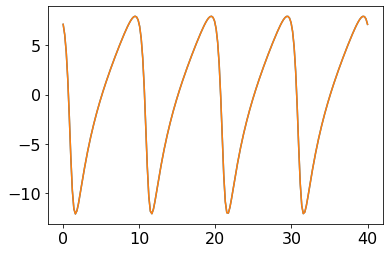

In [35]:
period = 10
tp =1
e = 0.5
om = 2
K = 10
times = np.linspace(0,40,200)
Tprecess = 50 * period
# omegadot = 2 * np.pi /Tprecess

rv_signal = radvel.kepler.rv_drive(times,[period,tp,e,om,K])

secos, sesin = np.sqrt(e) * np.cos(om), np.sqrt(e) * np.sin(om)
test_pars = [period, K, radvel.orbit.timeperi_to_timetrans(tp, period, e, om), secos, sesin, 0]

plt.plot(times,rv_signal)
plt.plot(times, get_rvs(test_pars, inclination=np.pi/2, times=times, integrator='ias15', time_base=0))

In [27]:
tp, radvel.orbit.timetrans_to_timeperi(radvel.orbit.timeperi_to_timetrans(tp, period, e, om), period, e, om)

(1, 1.0)

In [28]:
get_rvs(test_pars, inclination=np.pi/2, times=times, integrator='ias15', time_base=0), rv_signal

(array([  7.09907301,   6.06821336,   4.31093564,   1.56798682,
         -2.18971176,  -6.34083883,  -9.71066856, -11.56792166,
        -12.07955012, -11.76427595, -11.03939384, -10.14669208,
         -9.20859091,  -8.28259797,  -7.39358398,  -6.55052531,
         -5.75483968,  -5.00449495,  -4.29602949,  -3.62553829,
         -2.98914286,  -2.38320197,  -1.8043928 ,  -1.24972807,
         -0.71654329,  -0.20247139,   0.29458634,   0.77648833,
          1.24487778,   1.70120343,   2.14673543,   2.58257591,
          3.00966349,   3.42877092,   3.84049424,   4.24523129,
          4.64314592,   5.03411269,   5.41763386,   5.79271611,
          6.15768759,   6.50992459,   6.84543867,   7.15824423,
          7.43937399,   7.67531951,   7.84551925,   7.91825567,
          7.84391584,   7.54408278,   6.89501212,   5.70780291,
          3.72574022,   0.71346161,  -3.23269507,  -7.30118343,
        -10.32311174, -11.80253452, -12.05872741, -11.60933662,
        -10.82562996,  -9.91338694,  -8.

In [29]:
?get_rvs